In [10]:
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
        'model_size': 774_000_000,
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
        'model_size': 2_510_000_000,
    },
    'gemma-7b': {
        'recurring': None,#'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
        'model_size': 8_540_000_000,
    },
}

METHODS = ['recurring', 'greedy', 'baseline']

RECURRING_TIMESTEPS = 5

In [21]:
def conv_float(x):
    return float(x.replace(',', '')) if len(x) > 0 else float('-inf')

def get_accuracy(model_name, method, time_step=0):
    if MODELS_INFO[model_name][method] is None:
        return 0
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file))
    
    if method == 'recurring':
        if time_step > RECURRING_TIMESTEPS or time_step <= 0:
            raise ValueError('Invalid time step for recurring method')
        correct = 0
        for inst in output:
            index = time_step - 1
            if len(inst['majority_vote_answers']) < time_step:
                index = -1
            correct += int(conv_float(inst['majority_vote_answers'][index]) == conv_float(inst['ground_truth_answers']))
        return correct / len(output)
    elif method == 'baseline' or method == 'greedy':
        return sum(1 for inst in output if conv_float(inst['majority_vote_answer']) == conv_float(inst['ground_truth_answer'])) / len(output)
    raise ValueError('Invalid method')

In [22]:
plot_df = pd.DataFrame(columns=['model', 'method', 'accuracy', 'model_size'])

for model_name in MODELS_INFO:
    for method in METHODS:
        if method == 'recurring':
            for time_step in range(1, RECURRING_TIMESTEPS + 1):
                print(f'Processing {model_name} - {method} - {time_step}')
                plot_df = pd.concat([plot_df, pd.DataFrame([{
                    'model': model_name, 
                    'method': f'{method} - {time_step}', 
                    'accuracy': get_accuracy(model_name, method, time_step), 
                    'model_size': MODELS_INFO[model_name]['model_size']
                }])], ignore_index=True)
        else:
            print(f'Processing {model_name} - {method}')
            plot_df = pd.concat([plot_df, pd.DataFrame([{
                'model': model_name, 
                'method': method, 
                'accuracy': get_accuracy(model_name, method), 
                'model_size': MODELS_INFO[model_name]['model_size']
            }])], ignore_index=True)

Processing gpt2-large - recurring - 1


/tmp/ipykernel_126037/1181108208.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([{


Processing gpt2-large - recurring - 2
Processing gpt2-large - recurring - 3
Processing gpt2-large - recurring - 4
Processing gpt2-large - recurring - 5
Processing gpt2-large - greedy
Processing gpt2-large - baseline
Processing gemma-2b - recurring - 1
Processing gemma-2b - recurring - 2
Processing gemma-2b - recurring - 3
Processing gemma-2b - recurring - 4
Processing gemma-2b - recurring - 5
Processing gemma-2b - greedy
Processing gemma-2b - baseline
Processing gemma-7b - recurring - 1
Processing gemma-7b - recurring - 2
Processing gemma-7b - recurring - 3
Processing gemma-7b - recurring - 4
Processing gemma-7b - recurring - 5
Processing gemma-7b - greedy
Processing gemma-7b - baseline


In [15]:
plot_df

,model,method,accuracy,model_size
0,gpt2-large,recurring - 1,0.020701,774000000
1,gpt2-large,recurring - 2,0.017857,774000000
2,gpt2-large,recurring - 3,0.017971,774000000
3,gpt2-large,recurring - 4,0.016492,774000000
4,gpt2-large,recurring - 5,0.016833,774000000
5,gpt2-large,greedy,0.013421,774000000
6,gpt2-large,baseline,0.020018,774000000
7,gemma-2b,recurring - 1,0.223612,2510000000
8,gemma-2b,recurring - 2,0.219404,2510000000
9,gemma-2b,recurring - 3,0.226683,2510000000


[]

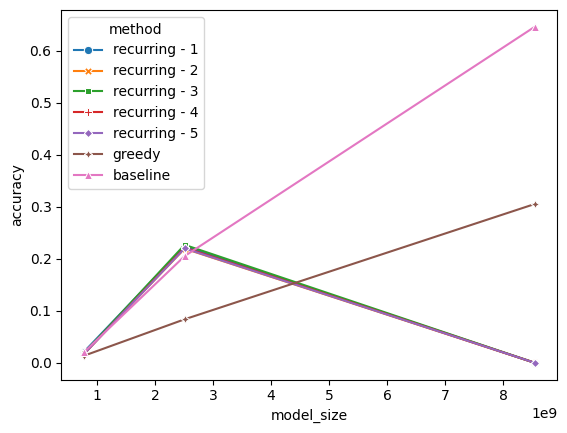

In [24]:
sns.lineplot(data=plot_df, x='model_size', y='accuracy', hue='method', style='method', markers=True, dashes=False)
plt.plot()